<div style="display: flex; align-items: center;margin-bottom: 30px;color: #8EB944">
    <img src=https://wisoinbox.uni-koeln.de/images/wiso_button_en.png width="80"> 
    <span style="margin-left: 20px;font-size: 50px;font-weight:bold";>Group Project: Prescriptive Analytics</span>
</div>

<div>
    <span style="font-size: 20px;font-weight: bold";>Group Members:</span>

<ul>
    <li>Tom Boerrigter | 7419077</li>
    <li>Niklas Sterz | 7419545</li>
</ul>
</div>

<div style="margin-top: 30px;">
    <span style ="font-size: 40px; font-weight: bold; color: #8EB944;">
        Question 2
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 1: Make assumptions
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
    <div style ="text-align: justify; display: block; font-size: 15px;">
        <span style="font-weight: bold;"> Assumptions: </span>
            <ol type='1', style="padding-left: 40px;">
                <li> As mentioned above, we will use the order of weekdays derived from the data in question 1 for all questions from now on. All final schedules and DataFrames will start with Tuesday and end with Monday. However, this does not affect the cyclical nature of the model, as all shifts could theoretically be rearranged to start with Monday without changing the final solution.</li>
                <li> The demand is assumed to be deterministic. Since we're providing a model that doesn't allow for any undercoverage, we have to aggregate the $ 168 \times 14 $ DataFrame into an $ 21 \times 1 $ vector that covers all the shifts. By doing this we assume that demand is not stochastic. </li>
                <li>  To aggregate the data, we need to find the expected demand for each hour. It is assumed that the average is a good representation of demand. An alternative assumption would be to use the maximum for each hour, which would give a more pessimistic solution. </li>
                <li> In order to derive an accurate demand figure for each shift, we assume that the data is free of noise. To get an accurate representation of demand, the time of week should be the only predictor variable in our model. </li>
                <li> We assume that one doctor must be present at all times to cover emergencies. This increases the demand for some of the night shifts by one in our demand calculation.  </li>
            </ol>
    </div>
</div>

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 1: Transform the data
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
    <span style ="text-align: justify; display: block; font-size: 15px;">
        <b>Explanation</b>:To calculate the expected demand for doctors in a given shift, we first need to calculate the demand for each hour in a week. To do this, we first calculate the average for each hour over the 14 weeks, which gives us a vector of $ 168 \times 1 $. Then, to "cover the demand [...] at each hour", we need to take the maximum value for each shift, i.e. for each 8-hour interval in the vector. This results in a final $21 \times 1$ demand vector.
    </span>
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Calculation of the demand
</span>


In [8]:
# Create an array with the shift names in the correct order
Days = ['Tue','Wed','Thu','Fri','Sat','Sun','Mon',]
Times = ['Night','Early','Late']
shifts_1 = [day+': '+time for day in Days
               for time in Times]

# Convert the DataFrame with the demand to a list
data_demand = pd.DataFrame.copy(data)
data_demand.drop('index',axis=1,inplace=True)
demand_list = data_demand.values.tolist()

# Use list comprehension to get the average demand for each hour over the 14 weeks   
demand_hour = [math.ceil(np.mean(i)) for i in demand_list]

# Calculate the demand per shift by getting the max value for each 8-hour interval
# We will use this array in GUROBI
demand = [(np.max(demand_hour[i*8:i*8+8])) for i in range(21)]

# Create a DataFrame to display the final demand
max_demand_per_shift = pd.DataFrame({'Shift': shifts_1, 'Demand': demand})
max_demand_per_shift.style.format(precision=0).hide().set_table_styles([
    {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'thead th:not(.index_name)', 'props': 'background-color: #8EB944; color: black; text-align: center;'}
])

Shift,Demand
Tue: Night,7
Tue: Early,11
Tue: Late,5
Wed: Night,7
Wed: Early,11
Wed: Late,5
Thu: Night,3
Thu: Early,10
Thu: Late,5
Fri: Night,7


<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 2: Define and explain the sets and subsets
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
    <span style ="text-align: justify; display: block; font-size: 15px;">
        <b>Explanation</b>: To understand the model, it is important to explain each used set and subset OF THE SHIFTS?. The whole set of shifts is defined as \(\{ 1,2,...,21 \} \in J\). Each individual shift in the set is defined as \(j \in J\). Since we need to differentiate between the type of the shift, e.g. early or late, three additional subsets are introduced. These are called \(k \in J\), where each \(k\) contains all the shifts of one type, so for exmaple \( \{ 1,4,7,10,13,16,19 \} \in k_{night}\). All sets and subsets are presented visually in the plot below.
    </span>
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Visualization of the sets
</span>


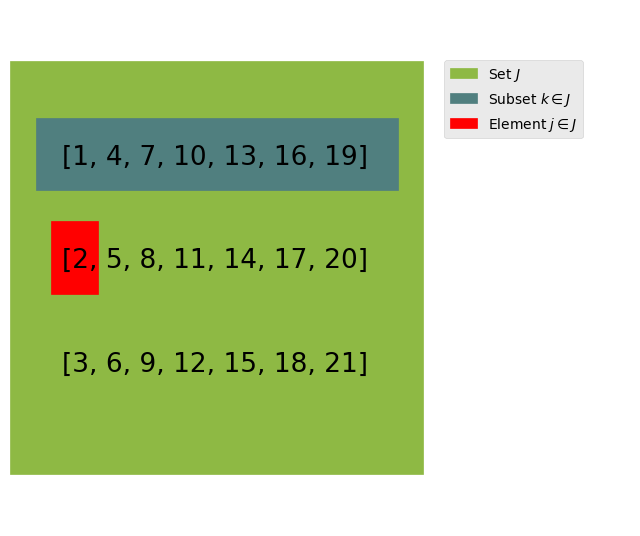

In [9]:
# Create a subset of the early, late and night shifts
K = [[0,3,6,9,12,15,18],
     [1,4,7,10,13,16,19],
     [2,5,8,11,14,17,20]]

# Create a subplot to show the sets
fig, ax = plt.subplots(figsize=(8,10))

# Add the text
plt.text(0.1,0.7,[x+1 for x in K[0]], color = 'black', fontsize = 19)
plt.text(0.1,0.5,[x+1 for x in K[1]], color = 'black', fontsize = 19)
plt.text(0.1,0.3,[x+1 for x in K[2]], color = 'black', fontsize = 19)

# Create the circles needed
square_J = Rectangle((0.0, 0.1), 0.8, 0.8, color='#8EB944', fill=True, label = 'Set $J$')
square_k1 = Rectangle((0.05,0.65),0.7,0.14, color = '#507F7F', fill = True, label = 'Subset $k \in J$')
square_j = Rectangle((0.08,0.45),0.09,0.14, color = 'red', fill = True, label = 'Element $j \in J$')



# Remove the axes delimiters
ax.axis('off')

# Make sure that circles really look like circles and add them to the final plot
ax.set_aspect('equal', 'box')
ax.add_patch(square_J)
ax.add_patch(square_k1)
ax.add_patch(square_j)


# Set the x-limit of the plot
ax.set_xlim(0,1.2)

# set the position of the legend
ax.legend(loc=[0.7,0.75])

# show the plot
plt.show()

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 3: Model the problem mathematically
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

<div>
    <span style="font-size: 15px;";>
      \begin{align}
&\min \sum_{i \in I} q_{i} \\
&s.t. \nonumber \\
&x_{ij} \leq q_{i} &&\forall i\in I,\textrm{ }\forall j\in J\tag{1}\\
&\sum_{i \in I} x_{ij} \geq d_{j} &&\forall j\in J \tag{2} \\
&\sum_{i\in I } x_{ij} \geq 1 &&\forall j\in J \tag{3} \\
&\sum_{j\in J}  x_{ij} \leq 5 &&\forall i\in I  \tag{4} \\
&\sum_{j\in k} x_{ij} \leq M * z_{ik}&&\forall i\in I,\textrm{ }\forall k\in J \tag{5} \\
&z_{i1}+z_{i2}+z_{i3} \leq 2*q_{i} &&\forall i\in I \tag{6} \\
&x_{ij}+x_{i,j+1}+x_{i,j+2} \leq 1 &&\forall i\in I,\textrm{ }\forall J\in J \setminus \{20,21\}\tag{7} \\
&x_{i1}+x_{i2}+x_{i21} \leq 1 &&\forall i\in I \tag{8} \\
&x_{i1}+x_{i20}+x_{i21} \leq 1 &&\forall i\in I \tag{9} \\
& q_{i}, x_{ij},z_{ik}  \in \{0, 1\} && \forall i\in I,\textrm{ }\forall j\in J,\textrm{ }\forall k\in K \tag{10}
\end{align}
      
      
      
        
        
</span>
    
</div>

<div>
<span style="font-size: 15px;font-weight: bold;">Decision variables:</span>
<ul>
        <li>\(q_{i\phantom{1}} = \begin{cases}
            1 & \text{if doctor } i \text{ is hired,} \\
            0 & \text{otherwise}
        \end{cases}\)</li>
    <li>\(x_{ij} = \begin{cases}
            1 & \text{if doctor } i \text{ is scheduled for shift } j, \\
            0 & \text{otherwise}
        \end{cases}\)</li>
    <li>\(z_{ik} = \begin{cases}
            1 & \text{if doctor } i \text{ is scheduled for at least one shift of type } k, \\
            0 & \text{otherwise}
        \end{cases}\)</li>
</ul>
<div>
<span style="font-size: 15px;font-weight: bold;">Parameters:</span>
<ul>
 <li>\(d_{j} = \text{demand d in shift j} \text{}\)</li>
    <li>\(M  = \text{upper bound for amount of shifts of type } k \text{ doctor } i \text{ can work per week} \text{}\)</li>
</ul>
       


</div>   
     <span style ="text-align: justify; display: block; font-size: 15px;">
         <b>Explanation: </b>The objective function minimizes the sum of employed doctors. Constraint (1) connects the decision variables \(x_{ij}\) and \(q_{i}\), ensuring that each doctor in the schedule raises the objective function value by one. Constraint (2) ensures that the demand is at least met in each shift. If the demand for a shift is zero, at least one doctor has to be on duty, which is modeled in Constraint (3). Furthermore, each of the doctors isn't allowed to work more than 40 hours per week, meaning five shifts at most. This is taken care of in Constraint (4). Constraint (5) connects the variables \(z_{ik}\) and \(x_{ij}\). Therefore, \(z_{ik}\) has to be equal to one if at least one instance of \(x_{ij}\) itself is equal to one. For this purpose, \({M}\), a sufficiently large number, is introduced. Constraint (6) limits the sum of all selected shift types for each doctor to two when that particular doctor is employed. Constraints (7), (8) and (9) ensure, that each doctor gets at least 12 hours, or in other words two shifts, off between each shift on duty. The first of the three constraints limits the sum of three consecutive shifts on duty to two. Because the schedule is meant to be used in a cycle, Constraints (8) and (9) are needed so that no doctor is scheduled to work Monday night or early when he/she already worked Sunday late; or scheduled for Monday night if he/she worked Sunday early or late respectively. The last Constraint limits the solution area of the decision variables to one or zero.
    </span>

</div>

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 4: Implement the model in Gurobi
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Initialize the model
</span>


In [10]:
m = gp.Model('Work Plan')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-14


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Define the required sets
</span>


In [11]:
# =========================== Shifts j in J --> {1,2,3,...,21} =======================

J = range(21)


# =========================== Doctors i in I --> {1,2,3,...,100} ======================

I = range(100)


# =========================== Types of shift k in J  ==================================

K = [[0,3,6,9,12,15,18],    # indexes of all the night shifts  --> k=1
     [1,4,7,10,13,16,19],   # indexes of all the early shifts  --> k=2
     [2,5,8,11,14,17,20]]   # indexes of all the late shifts   --> k=3

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Initialize the decision variables
</span>

In [12]:
# =========================== Initialization of binary decision variables =======================

# Add the variable x_i which takes the value 1 for every doctor that is included in the final shift plan; 0 otherwise
q = m.addVars(I, vtype=GRB.BINARY, name="q")


# Add the variable x_ij which takes the value 1 if the i-th doctor works in the j-th shift; 0 otherwise
x = m.addVars(I, J, vtype=GRB.BINARY, name="x")


# Add the variable z_ik which takes the value 1 if the i-th doctor works in any shift of type k; 0 otherwise
z = m.addVars(I,range(3), vtype=GRB.BINARY, name="z")

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Specify the parameters
</span>

In [13]:
# M is a sufficiently large constant that serves as an upper bound  
M = 5

# Define the demand for each of the 21 shifts
d = demand

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Define the objective function
</span>

In [14]:
m.setObjective(gp.quicksum(q[i] for i in I), GRB.MINIMIZE)

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Add the constraints to the model
</span>

In [15]:
# ========================== Constraint (1) ==========================
for i in I:
    for j in J:
        m.addConstr(q[i] >= x[i, j],
                    f'''Constraint (1): Connection of decision 
                    variables q and x''')
        

# ========================== Constraint (2) ==========================

for j in J:
    m.addConstr(gp.quicksum(x[i, j] 
                    for i in I) >= d[j],
                    f"Constraint (2): Supply covers demand")

    
# ========================== Constraint (3) ==========================
for j in J:
    m.addConstr(gp.quicksum(x[i, j] 
                    for i in I) >= 1,
                    f"Constraint (3): Emergency duty")

    
# ========================== Constraint (4) ==========================
for i in I:
    m.addConstr(gp.quicksum(x[i, j] 
                    for j in J) <= 5,
                    f"Constraint (4): Work regulation (40 hours)")
    

# ========================== Constraint (5) ==========================
for i in I:
    for k in range(3): 
        m.addConstr(gp.quicksum(x[i, j] 
                        for j in K[k]) <= M * z[i, k],
                        f'''Constraint (5): Connection of 
                        decision variables z and x''')
        

# ========================== Constraint (6) ==========================
for i in I:
    m.addConstr(z[i, 0] + z[i, 1] + z[i, 2]
                <= 2*q[i],
                f"Constraint (6): Max two shift types k")

    
# ========================== Constraint (7) ==========================
for i in I:
    # Ensure j+2 does not exceed the number of shifts
    for j in J[:-2]:  
        m.addConstr(x[i, j] + x[i, j+1] + x[i, j+2]
                    <= 1,
                    f'''Constraint (7): Work regulation 2 
                    (12 hour break)''')
        

# ========================== Constraint (8) ==========================
for i in I:
    m.addConstr(x[i, 0] + x[i, 1] + x[i, 20]
                    <= 1,
                    f"Constraint (8): Week transition 1")

    
# ========================== Constraint (9) ==========================
for i in I:
    m.addConstr(x[i, 0] + x[i, 19] + x[i, 20] 
                    <= 1,
                    f"Constraint (9): Week transition 2")

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Solve the problem
</span>

In [16]:
m.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.1.0 23B81)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4742 rows, 2500 columns and 19600 nonzeros
Model fingerprint: 0xe7ad06a8
Variable types: 0 continuous, 2500 integer (2500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 46.0000000
Presolve removed 2121 rows and 0 columns
Presolve time: 0.03s
Presolved: 2621 rows, 2500 columns, 15400 nonzeros
Variable types: 0 continuous, 2500 integer (2500 binary)

Root relaxation: objective 2.400000e+01, 2207 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      24.0000000   

<div>

<span style ="text-align: justify; display: block; font-size: 15px;">
    <b>Interpretation: </b> The optimal solution derived from gurobi for the problem is 24. That is, the hospital would need to hire 24 physicians. One can also observe that there are 46 solutions with the same objective value. This is due to the fact that we gave gurobi a list of 100 doctors that could possibly be hired. A lower number would decrease the number of possible solutions.</span>

</div>

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 5: Print the final schedule
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

In [17]:
# Get the optimal schedule from the solution GUROBI provided
optimal_schedule = {(i, j): x[i, j].x for i in I for j in J}

# Create an array with the shift names and an extra column for the doctor names
shifts_2 = [day+': '+time for day in Days
               for time in Times]
shifts_2 = ['Name_of_the_doctors']+ shifts_2

# Create a DataFrame to show the schedule
schedule_docs = pd.DataFrame(index=I,columns=shifts_1)

# Populate the schedule DataFrame based on the optimal solution
for i in I:
    for j in J:
        schedule_docs.at[i, shifts_1[j]] = optimal_schedule.get((i, j), 0)
non_zero_rows = schedule_docs.any(axis=1)

# Filter the DataFrame to keep only the rows with at least one non-zero value
schedule_docs = schedule_docs[non_zero_rows]

# Replace the Zeros and Ones with emojis
schedule_disp = schedule_docs.replace(1.0,emoji.emojize(":health_worker:", variant="emoji_type"))
schedule_disp = schedule_disp.replace(0.0,emoji.emojize(":Statue_of_Liberty:", variant="emoji_type"))

# Create a column for the doctor names
doctor = [0]*len(schedule_disp)
for k in range(len(schedule_disp)):
    Faker.seed(k)
    Name = fake.name()
    doctor[k] = f'Dr. {Name}'
schedule_disp['Name_of_the_doctors'] = doctor

# Insert the last column at the beginning (position 0)
last_column = schedule_disp.pop(schedule_disp.columns[-1])
schedule_disp.insert(0, last_column.name, last_column)

# Style the dataframe
schedule_disp = schedule_disp.style.set_table_styles([
    {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'thead th:not(.index_name)', 'props': 'background-color: #8EB944; color: black; text-align: center;'}
]).hide().set_caption(
    '<span style="font-size: 25px; font-weight: bold;">Final Schedule for deterministic Demand</span>')


# Show the whole DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)
 
display(schedule_disp)
 
# Resets the options
pd.set_option('mode.use_inf_as_na', True)

Name_of_the_doctors,Tue: Night,Tue: Early,Tue: Late,Wed: Night,Wed: Early,Wed: Late,Thu: Night,Thu: Early,Thu: Late,Fri: Night,Fri: Early,Fri: Late,Sat: Night,Sat: Early,Sat: Late,Sun: Night,Sun: Early,Sun: Late,Mon: Night,Mon: Early,Mon: Late
Dr. Norma Fisher,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽
Dr. Ryan Gallagher,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽
Dr. Theresa Brown,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️
Dr. Joshua Wood,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️
Dr. Brian Foster,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽
Dr. Natalie Pope,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️
Dr. Samantha Washington,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽
Dr. Chris Curtis,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽
Dr. Victor Martinez,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽
Dr. James Taylor,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽


<div>
<span style="font-size: 15px;font-weight: bold;">Explanation of symbols:</span>
<ul>
    <li>\(x_{ij} = \begin{cases}
            🧑 & \text{if doctor } i \text{ is scheduled for shift } j, \\
            🗽 & \text{otherwise}
        \end{cases}\)</li>
</ul>
</div>

<div>

<span style ="text-align: justify; display: block; font-size: 15px;">
    <b>Summary: </b>This DataFrame shows an example for the final schedule we derived from the model. As the constraint regarding the maximum number of shift types is quite complicated, we can check if it has been implemented correctly by looking at the shifts for each doctor. In fact, most doctors work two shifts, the early shift, because it is the one with the highest demand, and either the night shift or the late shift. In addition, no doctor works more than 5 shifts and always has a 12-hour break. We can also check that we haven't forgotten any constraints regarding the cyclical nature of the schedule, which is not the case. <br>The schedules also confirm our theory from question 1, as there are usually only one or two doctors scheduled for weekend days and night shifts. Again, the clusters are clearly visible.</span>

</div>

<div style="margin-top: 30px;">
    <span style ="font-size: 40px; font-weight: bold; color: #8EB944">
        Question 3
    </span>
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">    

</div>

<div>
    <span style ="font-size: 23px; font-weight: bold; color: #8EB944">
        a) What is the total  undercoverage of demand measured in physician-hours per shift?
    </span>
</div>

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 1: Make assumptions on how to calculate the undercoverage
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>


<div>
    <span style="text-align: justify; display: block; font-size: 15px;">
        <b>General assumptions</b>: We assume that the 14 weeks are the "given scenarios". Alternatively, one could create new scenarios by estimating random distributions for each of the 168 hours in a week, then drawing a random value from each distribution and repeating this n times. In this way, we could generate many more scenarios and thus obtain a complete distribution of undercoverage per shift. However, this would be computationally expensive, as we would need to estimate 168 distributions and run at least 1000 simulations. In addition, we could not present the undercoverage for all scenarios in matrix form. Using the 14 weeks corresponds to a 14 x 21 matrix, while a true simulation yields a 1000 x 21 matrix. For this reason, we stick to the 14 weeks as the given scenarios.
            </span>
                <br> <!-- New line here -->
                        <br> <!-- New line here -->
        <span style="text-align: justify; display: block; font-size: 15px;">
        <b>Task specific assumptions</b>: To determine the total undercoverage in physician hours, we must first calculate the undercoverage for each of the 168 hours, since doing so on a per-shift basis would cause the undercoverage and overcoverage to cancel each other out. Thus, we must take the maximum of 0 and the difference between supply and demand in a given shift, week, and hour, and then sum it for each shift. This logic is presented in mathematical form below:
                \[
        \sum_{n=1}^{8}\max (0,\sum_{i \in I}x_{ij}-d_{jns}) \quad \quad \forall j\in J\textrm{ }\forall s\in S.
        \]
    </span>
    <div>

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 2: Get the supply and demand 
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>



<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Get the supply per shift derived from our model
</span>


In [18]:
# The following dataframe schedule_docs contains the numerical solution derived from the model used in question 2. 
# That is , the work plan in a raw form.
coverage = schedule_docs

# We need to aggregate the columns, that is, sum up all the doctors that work in the corresponding shift.
# To do so, let us create a dictionary that captures how many doctors work in a particular shift, based on the optimal solution from our model.

supply_per_shift = {
    shifts_1[i]:
        coverage.sum()[i]
    for i in range(21)
    }

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Get the demand of physicians on an hourly basis
</span>

In [19]:
# First, we create a variable that points to the dataframe that was loaded in from the .csv file.
# This contains the demand of physicians on an hourly basis in a 168x14  matrix.
demand_per_hour = pd.read_csv('Project_Data.csv', sep=';')
# Drop the index column
demand_per_hour.drop('index',axis=1,inplace=True)



# we also create a dictionary that maps the hours to the shifts, so that we can easily access the supply_per_shift dictionary in the next step
shifts_168 = [i for i in shifts_1 for x in range(8)]
hour_to_shift = dict(enumerate(shifts_168))

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 3: Calculate the the undercoverage on an hourly basis
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

In [20]:
# We  iterate over all rows and columns from the demand_per_hour dataframe, which contains the demand of doctors for all hours in all weeks


# iterate over the columns of the dataframe

# create an empty dictionary, that later maps the undercoverage per shift to the weeks
undercoverage_per_hour = {}
for week in demand_per_hour.columns:
    
    # initialize an empty list of length 168, that will later contain undercoverage per hour in a given week
    undercoverage = [0]*168
    
    
    # iterate over the 168 rows of each column
    for i in range(168):
        # get the shift that corresponds to the i-th hour
        idx = hour_to_shift[i]
        
        # calculate the undercoverage in hours, if there is undercoverage
        if demand_per_hour[week][i]>supply_per_shift[idx]:
            undercoverage[i] = (demand_per_hour[week][i]-supply_per_shift[idx])
            
    # add the undercoverage for all 168 hours in the j-th week to the dictionary
    undercoverage_per_hour[week] = undercoverage

    
# convert the dictionary to a pd.DataFrame for easier aggregation

undercoverage_per_hour = pd.DataFrame(undercoverage_per_hour)

# use dictionary comprehension to aggregate the data by the maximum doctors needed in a given shift
undercoverage_per_hour={shifts_1[i]:undercoverage_per_hour[i*8:i*8+8].sum() 
                 for i in range(21)}

undercoverage_per_shift = pd.DataFrame(undercoverage_per_hour)

undercoverage_per_shift = undercoverage_per_shift.T

undercoverage_per_shift = undercoverage_per_shift.style.format(precision =2).background_gradient(cmap = 'binary', axis=None).set_table_styles([
     {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'thead th:not(.index_name), tbody tr th:first-child', 
     'props': 'background-color: #8EB944; color: black; text-align: center;'}
]).set_caption(
    '<span style="font-size: 25px; font-weight: bold;">Total Undercoverage per Shift</span>')


<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 4: Display the the undercoverage per shift for all scenarios
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

In [21]:
undercoverage_per_shift

,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13,Week 14
Tue: Night,0.00,0.00,1.00,2.00,0.00,0.00,2.00,0.00,3.00,2.00,2.00,0.00,0.00,0.00
Tue: Early,1.00,1.00,1.00,0.00,3.00,0.00,1.00,9.00,1.00,0.00,1.00,2.00,1.00,0.00
Tue: Late,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00
Wed: Night,0.00,0.00,1.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00,3.00,1.00,0.00,0.00
Wed: Early,4.00,5.00,0.00,0.00,3.00,1.00,0.00,7.00,5.00,0.00,1.00,4.00,0.00,0.00
Wed: Late,0.00,0.00,1.00,0.00,0.00,0.00,1.00,4.00,1.00,0.00,0.00,0.00,0.00,3.00
Thu: Night,0.00,1.00,0.00,0.00,0.00,0.00,0.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00
Thu: Early,5.00,0.00,2.00,0.00,3.00,1.00,0.00,2.00,3.00,0.00,0.00,10.00,0.00,0.00
Thu: Late,6.00,1.00,2.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,0.00,2.00
Fri: Night,0.00,2.00,1.00,0.00,2.00,0.00,0.00,1.00,0.00,0.00,4.00,0.00,0.00,0.00


<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 5: Interpret the results
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

<div>

<span style ="text-align: justify; display: block; font-size: 15px;">
    <b>Interpretation:</b> It can be seen that in the vast majority of shifts there are accumulated undercoverage hours of less than 5 hours or even 0 hours. This means that the solution performs quite well in all scenarios, even though we only optimized by covering the expected demand. However, in some shifts, such as the Saturday night shift or the early Thursday shift, the assumption that the demand is represented by the expected demand does not seem to hold. For the Saturday night shift in week 10, our solution would not perform well, there would be 2 doctors missing in each of the 8 hours of the shift. This result could be due to outliers in the data, since we only considered the mean and not the full distribution of demand. Overall, the undercoverage is not distributed systematically, but the majority of shifts with undercoverage hours in multiple scenarios are in the shifts we previously categorized as clusters. This makes sense because the mean and standard deviation for the shifts in the clusters are higher than for the other shifts.
    </span>

</div>

<div>
    <span style ="font-size: 23px; font-weight: bold; color: #8EB944">
        b) What is the average utilization of physicians per shift?
    </span>
</div>

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 1: Make assumptions on how to calculate the utilization
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>


<div>
        <span style="text-align: justify; display: block; font-size: 15px;">
        <b>Assumptions</b>: The general assumptions made in a) hold for this task as well. To determine the average utilization per shift, we must first calculate the utilization for each of the 168 hours, since doing so on a per-shift basis would cause the undercoverage and overcoverage to cancel each other out. When there is undercoverage in a given hour, the utilization is 1. Then, we must take the average of the sum of utilizations to get the average utilization per shift. This logic is presented in mathematical form below:
                \[
        \frac{1}{8}\sum_{n=1}^{8}\min (\frac{d_{jns}}{\sum_{i \in I}x_{ij}},1)\quad\quad\forall j\in J,\textrm{ }\forall s\in S .
        \]
    </span>
    <div>

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 2: Calculate the utilization
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Get the average utilization
</span>

In [22]:
##### We can reuse all the dictionaries and variables that have been created in Step 2 of questions 3 a) #####

# create an empty dictionary, that later maps the utilization of doctors per shift to the weeks
utilization_total = {}

# iterate over all j weeks 
for week in demand_per_hour.columns:
    
    # initialize an empty list of length 168, that will later contain undercoverage per hour in a given week
    utilization_week = [0.0]*168
    
    
    # iterate over all the 168 hours 
    for i in range(168):
        
        # get the shift that corresponds to the i-th hour
        idx = hour_to_shift[i]
        
        # when there is undercoverage, the utilizitation of doctors is 100% (1)
        if demand_per_hour[week][i]>supply_per_shift[idx]:
            utilization_week[i] = 1.0
        
        # Divide demand in a certain by the supply in the corresponding shift
        else:
            utilization_week[i] = np.round(demand_per_hour[week][i]/supply_per_shift[idx],2)
            
    # add the undercoverage for all 168 hours in the j-th week to the dictionary
    utilization_total[week] = utilization_week

    
# convert the dictionary to a pd.DataFrame for easier aggregation

utilization_total = pd.DataFrame(utilization_total)

 # use dictionary comprehension to aggregate the data by the maximum doctors needed in a given shift
utilization_shift={shifts_1[i]:(utilization_total[i*8:i*8+8].mean().round(2))*100
                 for i in range(21)}

utilization_shift = pd.DataFrame(utilization_shift)

utilization_shift = utilization_shift.T

#final.drop('index',axis = 1,inplace = True)


utilization_shift = utilization_shift.style.format(precision =2).background_gradient(cmap = 'binary', axis=None).set_table_styles([
     {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'thead th:not(.index_name), tbody tr th:first-child', 
     'props': 'background-color: #8EB944; color: black; text-align: center;'}]).set_caption(
    '<span style="font-size: 25px; font-weight: bold;">Utilization per Shift in Percent</span>')

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 3: Display the the utilization per shift for all scenarios
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

In [23]:
utilization_shift

,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13,Week 14
Tue: Night,14.00,30.00,12.00,25.00,11.00,12.00,38.00,25.00,25.00,38.00,25.00,12.00,0.00,14.00
Tue: Early,91.00,78.00,81.00,82.00,84.00,84.00,65.00,93.00,77.00,80.00,76.00,92.00,80.00,81.00
Tue: Late,70.00,40.00,28.00,8.00,35.00,32.00,5.00,70.00,35.00,22.00,45.00,33.00,18.00,43.00
Wed: Night,59.00,25.00,12.00,9.00,12.00,12.00,12.00,38.00,27.00,12.00,38.00,12.00,0.00,22.00
Wed: Early,92.00,89.00,85.00,57.00,91.00,83.00,81.00,94.00,75.00,82.00,85.00,93.00,59.00,80.00
Wed: Late,45.00,30.00,25.00,2.00,55.00,35.00,52.00,92.00,35.00,32.00,32.00,48.00,2.00,62.00
Thu: Night,33.00,38.00,8.00,4.00,33.00,41.00,67.00,100.00,46.00,37.00,37.00,67.00,0.00,42.00
Thu: Early,91.00,84.00,91.00,66.00,91.00,82.00,80.00,80.00,84.00,82.00,72.00,94.00,60.00,74.00
Thu: Late,62.00,52.00,42.00,65.00,43.00,18.00,22.00,55.00,43.00,57.00,25.00,28.00,12.00,75.00
Fri: Night,57.00,36.00,12.00,12.00,38.00,11.00,12.00,25.00,25.00,25.00,61.00,9.00,0.00,0.00


<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 4: Interpret the results
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

<div>

<span style ="text-align: justify; display: block; font-size: 15px;">
    <b>Interpretation:</b> Every hospital would try to achieve an average occupancy rate close to 100% for all shifts, since physicians are expensive employees, but they do not want to risk undercoverage. It can be seen that during the shifts in the cluster, that is the early shift on weekdays, the average utilization for most scenarios is between 75% and 95%, while it is quite low for most shifts outside the clusters. In addition, there are quite a few shifts with 0% utilization. This occurs when the actual demand on a shift is 0, but a physician is on call for emergencies. The shifts in scenarios with 100% utilization indicate that there may be undercoverage in this particular scenario, which can be confirmed by looking at the table of undercoverage hours above.  
    </span>
                        <br> <!-- New line here -->
        <span style="text-align: justify; display: block; font-size: 15px;">
        In summary, you can see the trade-off between utilization and underutilization by looking at both tables. One cannot simultaneously achieve high utilization without risking undercoverage when demand is not constant.  In shifts with undercoverage, we typically observe high utilization, while low utilization is associated with lower expected undercoverage.
    </span>

</div>

<div>
    <span style ="font-size: 23px; font-weight: bold; color: #8EB944">
        c) (1) How can your results be explained by the assumptions you took in Question 2?
    </span>
</div>

<div>
    <div style ="text-align: justify; display: block; font-size: 15px;">
        <p> <strong>Undercoverage:</strong> We have assumed that the average is a good representation of actual demand. However, outliers can disrupt this assumption and lead to undercoverage, as seen in week 10 in the Saturday night shift. There are several ways to determine demand, ranging from ultra-optimistic to ultra-pessimistic. Since we didn't use the maximum of every hour and every shift, we will always suffer from some undercoverage. Additionally, we assumed that there must always be a doctor on call for emergencies, there is almost no undercoverage during times of really low demand, such as night shifts.</p>
        
<p> <strong>Utilization:</strong> Utilization is typically poor during the night shift, especially during the Sunday night shift. At these times, the demand is zero, but due to our assumption that there must be a doctor present at all times, the utilization is always zero. For each shift, we chose the hour with the maximum demand value as the supply. Due to this assumption, the rest of the hours suffer from poor utilization. Since there is a trade-off between under- and over-utilization, the definition of demand determines the average utilization. The more risk-averse the demand is calculated, the lower the average utilization will be, as we do not want any under-utilization.</p>
            
</div>
</div>

<div>
    <span style ="font-size: 23px; font-weight: bold; color: #8EB944">
        c) (2) Would you change some of your assumptions based on your results of Parts a and b?
    </span>
</div>

<div style ="text-align: justify; display: block; font-size: 15px;">
        <p> There is a strong trade-off between underutilization and overutilization, depending on how risk-averse we want to be. This tradeoff can be influenced by how we calculate demand. Tailoring the demand calculation to the risk aversion of the hospital administrator seems like a reasonable approach, since you cannot have high utilization and low underutilization at the same time. Therefore, this question cannot be answered in a vacuum. Regarding the other constraint, that at least one doctor must be available at all times, it would be harmful to relax this constraint, since unexpected emergencies could lead to a catastrophe. Since we do not want to violate any work rules, we cannot change constraints 4-7, and constraints 8 and 9 are necessary to make the work schedule circular. Looking specifically at the data for the Saturday night shift, we might reconsider the assumption that the data is noiseless. Since we have assumed that time is the only predictor variable in the data, there may be some others that cause noise. The 14 scenarios may not be enough to get a full distribution of demand for each shift.</p>
            
</div>

<div style="margin-top: 30px;">
    <span style ="font-size: 40px; font-weight: bold; color: #8EB944">
        Question 4
    </span>
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">    

</div>

<div>
    <span style ="font-size: 23px; font-weight: bold; color: #8EB944">
        Perform a stochastic optimisation
    </span>
</div>

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 1: Make assumption on how to deal with the stochasticity
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
    <span style ="text-align: justify; display: block; font-size: 15px;">
</div>

<div>
    <span style="text-align: justify; display: block; font-size: 15px;">
        <b>Assumptions</b>: In analogy to question 3, we will assume that the 14 weeks are considered to be the "given scenarios". Before, we assumed a deterministic model by using the expected demand for each shift and therefore ignoring the scenarios. Now, we face uncertainty about the demand for physicians in each shift, but we still have to create a schedule that meets our requirements in all scenarios. Thus, stochasticity comes only from the demand side, while supply (the number of physicians hired by the hospital) remains deterministic. Therefore, the objective function and the 3 binary decision variables: \(x_{ij}\), \(q_i\), and \(z_{ik}\), as well as most of the constraints, remain unchanged. Constraint (2) from the original model is the only one that needs to be modified, as we need to introduce two new variables for under- and overcoverage. Furthermore, the demand will not be aggregated anymore, rather the demand in each shift, in each hour and each scenario is considered. The demand in the stochastic model will be called \(d_{jns}\).
    </span>
    <br> <!-- Visible empty line -->
    <p style="text-align: justify; font-size: 15px;">
        The model in question 2 didn't specifically allow for undercoverage, it just resulted from demand in a shift not matching the expected value of demand in that particular shift. Therefore, if there are outliers, there could be quite a bit of unintended and arbitrarily distributed undercoverage. In our extended model, we minimize the number of physicians so that the expected undercoverage for each of the 21 shifts is at most 1 hour. Thus, we sum the undercoverage hours for each shift in each of the 14 scenarios and take the mean, which we then constrain. In doing so, we explicitly introduce an undercoverage, but an evenly distributed one. This gives us a solution that is more robust to outliers, though not completely immune.
    </p>
</div>

<span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 2: Prepare the data
</span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Stochastic demand
</span>

In [24]:
# Import the provided data
data = pd.read_csv("Project_Data.csv", sep=';') 

demand_stoch = data.drop('index', axis = 1, inplace = False) 

# create a multidimensional numpy array with the demand in each hour, scenario and shift
demand_st = demand_stoch.values

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 3: Extend the Model from Question 2
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

\begin{align}
&\min \ \sum_{i\in I}q_{i} \\
&s.t. \nonumber \\
&{ x_{ij} \leq q_{i}} &&\forall i\in I,\textrm{ }\forall j\in J\tag{1}\\
&\sum_{i \in I}x_{ij}-d_{jns}-o_{jns}+u_{jns} =0&&\forall j\in J,\textrm{ }\forall n\in N,\textrm{ }\forall s\in S \tag{2} \\
&\sum_{i\in I} x_{ij}+u_{jns} \geq d_{jns} &&\forall j\in J,\textrm{ }\forall n\in N,\textrm{ }\forall s\in S \tag{3} \\
&\sum_{i\in I} x_{ij}-o_{jns} \leq d_{jns} &&\forall j\in J,\textrm{ }\forall n\in N,\textrm{ }\forall s\in S \tag{4} \\
&u_{jns} \leq M_{1}*yu_{jns} &&\forall j\in J,\textrm{ }\forall n\in N,\textrm{ }\forall s\in S \tag{5} \\
&o_{jns} \leq M_{1}*yo_{jns} &&\forall j\in J,\textrm{ }\forall n\in N,\textrm{ }\forall s\in S \tag{6} \\
&yu_{jns} +yo_{jns}\leq 1 &&\forall j\in J,\textrm{ }\forall n\in N,\textrm{ }\forall s\in S \tag{7} \\
&\frac{1}{\left| S \right|}\sum_{s\in S}\sum_{n\in N}u_{jns} \leq 1 &&\forall j\in J \tag{8} \\
&\sum_{i\in I } x_{ij} \geq 1 &&\forall j\in J \tag{9} \\
&\sum_{j\in J}  x_{ij} \leq 5 &&\forall i\in I  \tag{10} \\
&\sum_{j\in k} x_{ij} \leq M_{2} * z_{ik}&&\forall i\in I,\textrm{ }\forall k\in J \tag{11} \\
&z_{i1}+z_{i2}+z_{i3} \leq 2 * q_{i} &&\forall i\in I \tag{12} \\
&x_{ij}+x_{i,j+1}+x_{i,j+2} \leq 1 &&\forall i\in I,\textrm{ }\forall J\in J \setminus \{20,21\}\tag{13} \\
&x_{i1}+x_{i2}+x_{i21} \leq 1 &&\forall i\in I \tag{14} \\
&x_{i1}+x_{i20}+x_{i21} \leq 1 &&\forall i\in I \tag{15} \\
& q_{i}, x_{ij},z_{ik}  \in \{0, 1\} && \forall i\in I,\textrm{ }\forall j\in J,\textrm{ }\forall k\in K\tag{16}\\
& yu_{jns} , yo_{jns} \in \{0, 1\} && \forall j\in J,\textrm{ }\forall n\in N,\textrm{ }\forall s\in S \tag{17}\\
&  u_{jns},o_{jns} \in \mathbb{N_{0}}&& \forall j \in J ,\textrm{ }\forall n\in N,\textrm{ }\forall s\in S \tag{18}
\end{align}

<div>
<span style="font-size: 15px;font-weight: bold;">Decision variables:</span>
<ul>
        <li>\(q_{i\phantom{1}\phantom{1}\phantom{1}} = \begin{cases}
            1 & \text{if doctor } i \text{ is hired,} \\
            0 & \text{otherwise}
        \end{cases}\)</li>
    <li>\(x_{ij\phantom{1}\phantom{1}} = \begin{cases}
            1 & \text{if doctor } i \text{ is scheduled for shift } j, \\
            0 & \text{otherwise}
        \end{cases}\)</li>
    <li>\(z_{ik\phantom{1}\phantom{1}} = \begin{cases}
            1 & \text{if doctor } i \text{ is scheduled for at least one shift of type } k, \\
            0 & \text{otherwise}
        \end{cases}\)</li>
        <li>\(yu_{jns} = \begin{cases}
            1 & \text{if there is undercoverage in shift } j \text{ in hour } n \text{ in scenario } s, \\
            0 & \text{otherwise}
        \end{cases}\)</li>
        <li>\(yo_{jns} = \begin{cases}
            1 & \text{if there is overcoverage in shift } j \text{ in hour } n \text{ in scenario } s, \\
            0 & \text{otherwise}
        \end{cases}\)</li>
    <li>\(u_{jns\phantom{1}} = \text{undercoverage (in doctor hours) in shift } j \text{ in hour } n \text { in scenario } s \)</li>
    <li>\(o_{jns\phantom{1}} = \text{overcoverage (in doctor hours) in shift } j \text{ in hour } n \text { in scenario } s\)</li>
<ul>
    
<div>

<div>
<span style="font-size: 15px;font-weight: bold;">Parameters:</span>
<ul>
    <li>\(d_{jns} = \text{demand d in shift } j \text{ in hour } n \text{ in scenario } s\)</li>
    <li>\(M_{1} = \text{upper bound for the over- and undercoverage hours} \)</li>
    <li>\(M_{2} = \text{upper bound for the number of shifts of type } k \text{ a doctor can work per week} \)</li>
</ul>

</div>

<div>
    <span style="text-align: justify; display: block; font-size: 15px;">
        <b>Explanation</b>: As mentioned above, the objective function, the 3 binary variables: \(x_{ij}\), \(q_i\), and \(z_{ik}\), as well as the constraints (1) and (9) - (16) remain unchanged in their content and meaning, only the enumeration has changed. For this reason, we will not explain the entire model again, but only the constraints that have been added or changed.
    </span>
                <br> <!-- Visible empty line -->
    <p style="text-align: justify; font-size: 15px;">
        To deal with stochasticity on the demand side, we introduce four new sets of variables, two of which are non-negative integers and two of which are binary. These variables: \(yu_{jns}\), \(yo_{jns}\), \(u_{jns}\) and \(o_{jns}\) are defined in the cell above and the constraints (17) and (18) formalize their definition ranges. In particular, the extended model allows for undercoverage, but to avoid overcoverage and undercoverage canceling each other out, we introduce two separate variables to avoid this while keeping the model linear instead of quadratic.
    </p>
    <p style="text-align: justify; font-size: 15px;">
        Constraint (2) limits the expected undercoverage for each shift across all scenarios to 1 physician hour. For each shift, we sum the undercoverage hours in all n hours in all s scenarios and divide this sum by the number of scenarios. Constraint (3) ensures that the supply of - minus the demand for physicians minus the overcoverage plus the undercoverage always equals 0. Thus, the undercoverage and overcoverage must bridge the gap between demand and supply. Constraints (4) and (5) ensure that \(u_{jns}\) is greater than 0 when demand is greater than supply, while \(o_{jns}\) is greater than 0 when supply is greater than demand.
    </p>
    <p style="text-align: justify; font-size: 15px;">
        Without constraints (6), (7), and (8), there could be simultaneous undercoverage and overcoverage, which occurs when demand and supply in a shift j, hour n, and scenario s are equal. Constraint (8) prohibits this by introducing an either or statement for the two binary variables \(yu_{jns}\) and \(yo_{jns}\) that indicate whether there is undercoverage or overcoverage in a given hour, shift, and scenario. Thus, we need four new sets of variables and six additional constraints to account for stochastic demand compared to the deterministic model from question 2.
    </p>
</div>

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 4: Implementation in Gurobi
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Initialize the extended model
</span>

In [25]:
# Create a new model for the stochastic problem
m2 = gp.Model('Stochastic optimization')

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Define the required sets
</span>

In [26]:
# =========================== Shifts j in J --> {1,2,3,...,21} =======================

J = range(21)


# =========================== Doctors i in I --> {1,2,3,...,100} ======================

I = range(100)


# =========================== Types of shift k in J  ==================================

K = [[0,3,6,9,12,15,18],    # indexes of all the night shifts  --> k=1
     [1,4,7,10,13,16,19],   # indexes of all the early shifts  --> k=2
     [2,5,8,11,14,17,20]]   # indexes of all the late shifts   --> k=3


# =========================== Hours n in N --> {1,2,3,...,8} ==========================

N = range(8)


# =========================== Scenarios s in S --> {1,2,3,...,14} =====================

S = range(14)

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Initialize the decision variables
</span>

In [27]:
# =========================== Initialization of binary variables =======================

# Add the variable x_i which takes the value 1 for every doctor that is included in the final shift plan; 0 otherwise
q = m2.addVars(I, vtype=GRB.BINARY, name="q")


# Add the variable x_ij which takes the value 1 if the i-th doctor works in the j-th shift; 0 otherwise
x = m2.addVars(I, J, vtype=GRB.BINARY, name="x")


# Add the variable z_ik which takes the value 1 if the i-th doctor works in any shift of type k; 0 otherwise
z = m2.addVars(I,range(3), vtype=GRB.BINARY, name="z")


# Add the variable y1_jns which takes the value 1 if there is undercoverage in the j-th shift in the n-th hour in s-th scenario
yu = m2.addVars(J, N, S, vtype=GRB.BINARY, name="yu")


# Add the variable y2_jns which takes the value 1 if there is overcoverage in the j-th shift in the n-th hour in s-th scenario
yo = m2.addVars(J, N, S, vtype=GRB.BINARY, name="yo")


# =========================== Initialization of the Integer variables =======================

# Add the variable u_jns which controlls the undercoverage in shift j, in hour n and scenario s. 
# The variable can only take on integers values that are >= 0, since none of the other variables or parameters are continuous.
u = m2.addVars(J, N, S,lb=0.0, vtype=GRB.INTEGER, name="u")


# Add the variable o_jns which controlls the overcoverage in shift j, in hour n and scenario s. 
# The variable can only take on integers values that are >= 0, since none of the other variables or parameters are continuous.
o = m2.addVars(J, N, S,lb=0.0, vtype=GRB.INTEGER, name="o")


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Declare the parameters
</span>

In [28]:
# M1 serves as an upper bound for the over- and undercoverage hours. 15 is the maximum demand of physicians in a single hour in the dataset.
M1 = 15  

# M2 serves as an upper bound for the number of shifts of type a doctor can work. 
# That is, every doctor can only work 5 early-, night- or late shifts.
M2 = 5



# Define the demand for each of the 21 shifts in each of the 8 hours per shift for each of the 14 scenarios.
d_2 = demand_st

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Specify the objective function
</span>

In [29]:
# =========================== Objective function =======================

# Minimize the number of physicians
m2.setObjective(gp.quicksum(q[i] 
                    for i in I),
                    GRB.MINIMIZE)

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Add the constraints from the model
</span>

In [30]:
# =============================== Constraint (1) ===============================


#
for i in I:
    for j in J:
        m2.addConstr(q[i] 
                         >= x[i, j],
                         f'''Constraint (1): Connection of decision variables 
                         q and x''')
        

# =============================== Constraint (2) ===============================

#
for j in J:
    for n in N:
        for s in S:
            m2.addConstr(gp.quicksum(x[i, j] for i in I) 
                             - d_2[j * 8 + n][s] 
                             + u[j,n,s] - o[j,n,s] 
                             == 0,
                             f'''Constraint (2): Ensure over- and undercoverage 
                             are calculated correctly''')

            
# =============================== Constraint (3) ===============================

# 
for j in J:
    for n in N:
        for s in S:
            m2.addConstr(gp.quicksum(x[i, j] for i in I)
                             +u[j,n,s] 
                             >= d_2[j * 8 + n][s],
                             f'Constraint (3): Calculate undercoverage')
            
             
# =============================== Constraint (4) ===============================
                        
# 
for j in J:
    for n in N:
        for s in S:
            m2.addConstr(gp.quicksum(x[i, j] for i in I) 
                             - o[j,n,s] 
                             <= d_2[j * 8 + n][s],
                             f'Constraint (4): Calculate overcoverage')
     
    
    
# =============================== Constraint (5) ===============================

# 
for j in J:
    for n in N:
        for s in S:
            m2.addConstr(u[j,n,s] 
                             <= M1 * yu[j,n, s],
                             f'Constraint (5): Check for undercoverage')   
    
    
    
    
# =============================== Constraint (6) ===============================

# 
for j in J:
    for n in N:
        for s in S:
            m2.addConstr(o[j,n,s] 
                             <= M1 * yo[j,n, s],
                             f'Constraint (6): Check for overcoverage')   
    
    
    
# =============================== Constraint (7) ===============================

# 
for j in J:
    for n in N:
        for s in S:
            m2.addConstr(yu[j,n,s] + yo[j,n,s] 
                             <= 1,
                            f'''Constraint (7): Prohibit simultaneous under- 
                            and overcoverage''')   
    
    
    
    
    
# =============================== Constraint (8) ===============================

#
for j in J:
    m2.addConstr(1/14*(gp.quicksum((u[j, n, s])
                            for s in S
                            for n in N)) <= 1,
                            f"Constraint (8): Constrain expected undercoverage")
    

# =============================== Constraint (9) ===============================

#
for j in J:
    m2.addConstr(gp.quicksum(x[i, j] for i in I) 
                     >= 1,
                     f"Constraint (9): Emergency duty")
              
        
# =============================== Constraint (10) ===============================

#
for i in I:
    m2.addConstr(gp.quicksum(x[i, j] for j in J) 
                     <= 5,
                     f"Constraint (10): Work regulation 1 (40 hours)")
    
    
# =============================== Constraint (11) ===============================

#
for i in I:
    for k in range(3):  
        m2.addConstr(gp.quicksum(x[i, j] for j in K[k])
                         <= M2 * z[i, k],
                        f'''Constraint (11): Connection of 
                        decision variables z and x''')
            

# =============================== Constraint (12) ==============================

#
for i in I:
    m2.addConstr(z[i, 0] + z[i, 1] + z[i, 2] 
                     <= 2*q[i],
                     f"Constraint (12): Max two types of shift k")
    
    
# =============================== Constraint (13) ===============================

#
for i in I:
    # ensure that the index does not run out of range
    for j in J[:-2]:  
        m2.addConstr(x[i, j] + x[i, j+1] + x[i, j+2] 
                         <= 1,
                         f"Constraint (13): Work regulation 2 (12 hours break)")
            

# =============================== Constraint (14) ===============================

#
for i in I:
    m2.addConstr(x[i, 0] + x[i, 1] + x[i, 20] 
                     <= 1,
                     f"Constraint (14): Week transition 1")
        

# =============================== Constraint (15) ===============================

#
for i in I:
    m2.addConstr(x[i, 0] + x[i, 19] + x[i, 20] 
                     <= 1,
                     f"Constraint (15). Week transition 2")

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Solve the model
</span>

In [31]:
m2.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.1.0 23B81)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 18854 rows, 11908 columns and 748972 nonzeros
Model fingerprint: 0x74117df4
Variable types: 0 continuous, 11908 integer (7204 binary)
Coefficient statistics:
  Matrix range     [7e-02, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 13239 rows and 6413 columns
Presolve time: 0.86s
Presolved: 5615 rows, 5495 columns, 24469 nonzeros
Variable types: 0 continuous, 5495 integer (3562 binary)

Root relaxation: objective 2.451255e+01, 4808 iterations, 0.21 seconds (0.21 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   24.51255    0  473          -   24.51255      -     -    1s
H    0     

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 5: Display the schedule corresponding to the optimal solution
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

In [32]:
# Get the optimal schedule from the solution GUROBI provided
optimal_schedule2 = {(i, j): x[i, j].x for i in I for j in J}

# Create a DataFrame to show the schedule
columns = [f"Shift_{j}" for j in J]
schedule_docs2 = pd.DataFrame(index=I, columns=columns)

# Populate the schedule DataFrame based on the optimal solution
for i in I:
    for j in J:
        schedule_docs2.at[i, f"Shift_{j}"] = optimal_schedule2.get((i, j), 0)
non_zero_rows = schedule_docs2.any(axis=1)

# Filter the DataFrame to keep only the rows with at least one non-zero value
schedule_docs2 = schedule_docs2[non_zero_rows]

# Replace the Zeros and Ones with emojis
schedule_disp2 = schedule_docs2.replace(1.0,emoji.emojize(":health_worker:", variant="emoji_type"))
schedule_disp2 = schedule_disp2.replace(0.0,emoji.emojize(":Statue_of_Liberty:", variant="emoji_type"))

# Create a column for the doctor names
doctor = [0]*len(schedule_disp2)
for k in range(len(schedule_disp2)):
    Faker.seed(k)
    Name = fake.name()
    doctor[k] = f'Dr. {Name}'
schedule_disp2['Name_of_the_doctors'] = doctor

# Insert the last column at the beginning (position 0)
last_column = schedule_disp2.pop(schedule_disp2.columns[-1])
schedule_disp2.insert(0, last_column.name, last_column)

# Create a copy of the schedule
#schedule_disp = pd.DataFrame.copy(schedule_disp)

# Create an array with the schedule names
Days = ['Tue','Wed','Thu','Fri','Sat','Sun','Mon',]
Times = ['Night','Early','Late']
shift_names = ['Name_of_the_doctor']
for i in Days:
    for x in Times:
        shift_names.append(f"{i}: {x}")

# Reset the old index
schedule_disp2 = schedule_disp2.reset_index(drop=True)

# Create a dictionary mapping old column names to new column names
column_mapping = {old_name: new_name for old_name, new_name in zip(schedule_disp2.columns, shift_names)}

# Rename the columns in the DataFrame
schedule_disp2.rename(columns=column_mapping, inplace=True)

# Style the dataframe
schedule_disp2 = schedule_disp2.style.set_table_styles([
      {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'thead th:not(.index_name), tbody tr th:first-child', 
     'props': 'background-color: #8EB944; color: black; text-align: center;'}]).hide().set_caption(
    '<span style="font-size: 25px; font-weight: bold;">Final Schedule for stochastic Demand</span>')

# Show the whole DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)
 
display(schedule_disp2)
 
# Resets the options
pd.set_option('mode.use_inf_as_na', True)

Name_of_the_doctor,Tue: Night,Tue: Early,Tue: Late,Wed: Night,Wed: Early,Wed: Late,Thu: Night,Thu: Early,Thu: Late,Fri: Night,Fri: Early,Fri: Late,Sat: Night,Sat: Early,Sat: Late,Sun: Night,Sun: Early,Sun: Late,Mon: Night,Mon: Early,Mon: Late
Dr. Norma Fisher,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽
Dr. Ryan Gallagher,🗽,🧑‍⚕️,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽
Dr. Theresa Brown,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽
Dr. Joshua Wood,🧑‍⚕️,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽
Dr. Brian Foster,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽
Dr. Natalie Pope,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽
Dr. Samantha Washington,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽
Dr. Chris Curtis,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️
Dr. Victor Martinez,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽
Dr. James Taylor,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🧑‍⚕️,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🗽,🧑‍⚕️,🗽


<div>
<span style="font-size: 15px;font-weight: bold;">Explanation of symbols:</span>
<ul>
    <li>\(x_{ij} = \begin{cases}
            🧑 & \text{if doctor } i \text{ is scheduled for shift } j, \\
            🗽 & \text{otherwise}
        \end{cases}\)</li>
</ul>
</div>

<div>
    <span style="text-align: justify; display: block; font-size: 15px;">
        <b>Interpretation</b>: One can observe that compared to the deterministic model, the hospital would need to hire one additional doctor, when allowing for only one physician hour of expected undercoverage in each shift. Furthermore, one can see that none of the work regulations are violated. Alternatively, one could print the binary decision variables \(x_{ij}\), \(q_i\), and \(z_{ik}\) to confirm that the model is implemented correctly.
    </span>
    </div>

<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 6: Show the undercoverage for all shifts and scenarios
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Create a dictionary that captures how many doctors work in a particular shift
</span>

In [33]:
# the following dataframe schedule_docs2  represents the numerical solution derived from our model, that is , the work plan in a raw form
coverage2 = schedule_docs2


# we need to aggregate the columns, that is, sum up all the doctors that work in the corresponding shift
# use the dict comprehension to aggregate the data
supply2_per_shift = {
    shifts_1[i]:
        coverage2.sum()[i]
    for i in range(21)
    }
# display the resulting dictionary
supply2_per_shift

{'Tue: Night': 7.0,
 'Tue: Early': 12.0,
 'Tue: Late': 4.0,
 'Wed: Night': 7.0,
 'Wed: Early': 12.0,
 'Wed: Late': 5.0,
 'Thu: Night': 3.0,
 'Thu: Early': 11.0,
 'Thu: Late': 5.0,
 'Fri: Night': 7.0,
 'Fri: Early': 12.0,
 'Fri: Late': 5.0,
 'Sat: Night': 3.0,
 'Sat: Early': 2.0,
 'Sat: Late': 2.0,
 'Sun: Night': 1.0,
 'Sun: Early': 1.0,
 'Sun: Late': 1.0,
 'Mon: Night': 5.0,
 'Mon: Early': 12.0,
 'Mon: Late': 6.0}

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Calculate the undercoverage per shift for all scenarios
</span>.

In [34]:
# We  iterate over all rows and columns from the demand_per_hour dataframe, which contains the demand of doctors for all hours in all weeks


# create an empty dictionary, that later maps the undercoverage per hour to the weeks
undercoverage2_per_hour = {}

# ============================================ Calculate the undercoverage on an hourly basis =================================================

# iterate over the 14 weeks
for week in demand_per_hour.columns:
    
    # initialize an empty list of length 168, that will later contain the undercoverage for each hour in a given week
    undercoverage = [0]*168
    
    
    # iterate over the 168 rows of each column
    for i in range(168):
        
        # get the shift that corresponds to the i-th hour
        idx = hour_to_shift[i]
        
        # calculate the undercoverage in hours, if there is undercoverage. Otherwise the 0 will not be replaced.
        if demand_per_hour[week][i]>supply2_per_shift[idx]:
            undercoverage[i] = (demand_per_hour[week][i]-supply2_per_shift[idx])
            
    # add the undercoverage for all 168 hours in the j-th week to the dictionary
    undercoverage2_per_hour[week] = undercoverage





# =========================================== Aggregate the undercoverage on a per-shift level and display it =================================

# convert the dictionary to a pd.DataFrame for easier aggregation
undercoverage2_per_hour = pd.DataFrame(undercoverage2_per_hour)


# use dictionary comprehension to aggregate the data by the maximum doctors needed in a given shift
undercoverage2_per_shift={
    shifts_1[i]:undercoverage2_per_hour[i*8:i*8+8].sum() 
                 for i in range(21)
}

# Convert the dictionary to a Dataframe
undercoverage2_per_shift = pd.DataFrame(undercoverage2_per_shift)

# Transpose the dataframe
undercoverage2_per_shift = undercoverage2_per_shift.T


# Style the Dataframe 
undercoverage2_per_shift = undercoverage2_per_shift.style.format(precision =2).background_gradient(cmap = 'binary', axis=None).set_table_styles([
     {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'thead th:not(.index_name), tbody tr th:first-child', 
     'props': 'background-color: #8EB944; color: black; text-align: center;'}
])

# Display the undercoverages
undercoverage2_per_shift

,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13,Week 14
Tue: Night,0.00,0.00,1.00,2.00,0.00,0.00,2.00,0.00,3.00,2.00,2.00,0.00,0.00,0.00
Tue: Early,0.00,0.00,0.00,0.00,1.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00
Tue: Late,2.00,0.00,0.00,0.00,1.00,2.00,0.00,2.00,2.00,1.00,0.00,2.00,0.00,2.00
Wed: Night,0.00,0.00,1.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00,3.00,1.00,0.00,0.00
Wed: Early,1.00,1.00,0.00,0.00,1.00,0.00,0.00,3.00,2.00,0.00,0.00,1.00,0.00,0.00
Wed: Late,0.00,0.00,1.00,0.00,0.00,0.00,1.00,4.00,1.00,0.00,0.00,0.00,0.00,3.00
Thu: Night,0.00,1.00,0.00,0.00,0.00,0.00,0.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00
Thu: Early,2.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,2.00,0.00,0.00,6.00,0.00,0.00
Thu: Late,6.00,1.00,2.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,0.00,2.00
Fri: Night,0.00,2.00,1.00,0.00,2.00,0.00,0.00,1.00,0.00,0.00,4.00,0.00,0.00,0.00


<div>
    <span style ="font-size: 20px; font-weight: bold;color: #507F7F;">
        Step 7: Analyse the result
    </span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        How manyphysicians do you employ?
                            <br> <!-- New line here -->
    Do you have to employ more physicians than before?
                        <br> <!-- New line here -->
    Which restriction from question 2 is responsible for this difference?
</span>

<div>
    <span style="text-align: justify; display: block; font-size: 15px;">
        <b>Answer</b>: Remember that in the solution derived from the deterministic model, the hospital would have to hire 24 doctors. Now, in the solution derived from the stochastic model, they would need to hire 25 anesthesiologists. This small increase can be easily explained by looking at:
                <br> <!-- New line here -->
        constraint (2) from the stochastic model:  
        \[
        \frac{1}{\left| S \right|}\sum_{s\in S}\sum_{n\in N}u_{jns} \leq 1 \quad \forall j\in J
        \]
        and constraint (2) from the deterministic model:  
        \[
        \sum_{i \in I} x_{ij} \geq d_{j} \quad \forall j\in J. 
        \]
        Constraint (2) in the stochastic model explicitly allows for one expected undercoverage hour for each shift. Thus, theoretically, there could be up to 14 undercoverage hours in each shift for all scenarios. Therefore, the Gurobi optimizer can search for a solution that comes as close to this expected undercoverage as possible, since it is trying to minimize the number of physicians. 
    </span>
                    <br> <!-- New line here -->
        <p style="text-align: justify; font-size: 15px;">
        In contrast, constraint (2) in the deterministic model ensures that the expected demand in each hour must be met in each shift. Thus, there is no planned undercoverage. Undercoverage is only a result of actual demand deviating from expected demand. Therefore, the model cannot allocate the undercoverage hours.  Looking at the undercoverage tables for both solutions, we can see that the total undercoverage hours are higher in the deterministic model compared to the stochastic model. There are shifts in the deterministic model where the expected undercoverage per shift is more than one physician. Therefore, if the undercoverage is limited to one hour at most, the hospital would need to hire more physicians. Since there are few shifts with an expected undercoverage of more than one physician hour, it makes sense to hire only one additional anesthesiologist.
    </p>
                        <br> <!-- New line here -->
        <p style="text-align: justify; font-size: 15px;">
        Our solution for question 4is best suited for a risk-neutral hospital manager because the solution allows there to be 14 undercoverage hours in a shift in a particular scenario as long as there are 0 undercoverage hours for that particular shift in all of the other 13 scenarios. Alternatively, one could model constraint (2) differently to allow only 1 total undercoverage hour in each of the scenarios. This would be a much more risk-averse solution, forcing the hospital to hire even more physicians than in the deterministic model. The constraint would look like this:
                    \[
        \sum_{n\in N}u_{jns} \leq 1 \quad \forall j\in J,\textrm{ }\forall s\in S.
        \]
                                    <br> <!-- New line here -->
            Using this alternative constraint, the hospital would need to hire 31 physicians instead of 25, holding all else constant. Thus, the definition of what level of expected undercoverage is justifiable depends on the hospital administrator's risk aversion.
    </p>
</div>